Method 2: train MLP for the two groups(clustered by Kmeans) respectively

Some library imports & data loading functions first

In [116]:
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Flatten, BatchNormalization, PReLU, Dropout
from tensorflow.keras.models import Model, Sequential, model_from_json
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from joblib import dump, load
import warnings
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")
KMEANS_CLUSTER1_TRAIN = [0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 16, 17, 18, 19]
KMEANS_CLUSTER2_TRAIN = [2, 8, 9, 14, 15]
Y_LABEL = 'days_to_failure'

def load_unit_data(unit, folder):
    unit_name = "000{}".format(unit) if unit < 10 else "00{}".format(unit)
    return pd.read_csv("../data/processed/{}/unit{}_rms_anomaly_excluded.csv".format(folder, unit_name), index_col=0)

def load_all_data(units='all'):
    if units == 'all':
        units = range(0, 20)
    df_all = pd.DataFrame()
    for idx, unit in enumerate(units):
        file_name = "../data/processed/train/unit{}_rms_more_features.csv".format("000{}".format(unit) if unit < 10 else "00{}".format(unit))
        file_df = pd.read_csv(file_name, index_col=0)
        file_df['timestamp'] = pd.to_datetime(file_df['timestamp'])
        df_all = df_all.append(file_df)
    return df_all

def get_train_test_sets(df_input, test_size=0.2):
    df_input_features = df_input[df_input.columns[1:]]
    num_pipeline = Pipeline([('std_scaler', StandardScaler())])
    
    train_set, test_set = train_test_split(df_input_features, test_size=test_size, random_state=42)
    x_train = num_pipeline.fit_transform(train_set.drop(columns=[Y_LABEL], axis=1))
    x_test = num_pipeline.fit_transform(test_set.drop(columns=[Y_LABEL], axis=1))
    y_train, y_test = num_pipeline.fit_transform(train_set[[Y_LABEL]]), num_pipeline.fit_transform(test_set[[Y_LABEL]])
    return x_train, x_test, y_train, y_test

Train-test split the merged data of units in cluster 1, normalizing all inputs and label values.

In [108]:
df_c1 = load_all_data(units=KMEANS_CLUSTER1_TRAIN)
x_c1_train, x_c1_test, y_c1_train, y_c1_test = get_train_test_sets(df_c1)
df_c1

,timestamp,rpm,motor_voltage,motor_current,motor_temp,inlet_temp,days_to_failure,accumulated_warnings,accumulated_errors
53,2003-12-14 04:45:12.721247385,956.579922,217.484012,25.042943,63.002208,34.350839,636.535417,0,0
54,2003-12-14 04:55:40.840586778,1063.856934,206.792646,28.782024,69.830473,28.464714,636.528472,0,0
55,2003-12-14 05:05:37.291038943,1005.212018,219.900341,29.302032,68.019838,39.165607,636.521528,0,0
56,2003-12-14 05:17:06.465193131,1115.011284,220.373208,30.767473,79.283341,32.983723,636.513194,0,0
57,2003-12-14 05:25:31.807130176,1028.243351,194.055713,28.676094,75.055177,37.553089,636.507639,0,0
...,...,...,...,...,...,...,...,...,...
24341,2005-04-11 18:16:25.989419843,1042.179737,307.539123,47.975455,218.791347,100.807647,0.027778,53,1
24342,2005-04-11 18:26:55.689073846,1069.597134,297.454082,47.263750,218.882763,109.359761,0.020139,53,1
24343,2005-04-11 18:35:25.402556965,1116.392388,316.277175,50.395914,218.935540,102.472228,0.014583,53,1
24344,2005-04-11 18:45:44.900113142,1122.974015,320.776152,49.165122,225.527057,103.086940,0.006944,53,1


Construct Keras neural network for the dataset on cluster 1, using 5 dense layers, leaky ReLU activation, Adadelta optimization and Lecun init(tuned out to be the optimal). R square is used for evaluation metric

Keras model constructed
Train on 643024 samples, validate on 160757 samples
Epoch 1/300
643024/643024 [==============================] - 129s 201us/step - loss: 0.4748 - coeff_determination: 0.4989 - val_loss: 0.3988 - val_coeff_determination: 0.5844
Epoch 2/300
643024/643024 [==============================] - 122s 190us/step - loss: 0.3912 - coeff_determination: 0.5904 - val_loss: 0.3798 - val_coeff_determination: 0.6014
Epoch 3/300
643024/643024 [==============================] - 132s 206us/step - loss: 0.3789 - coeff_determination: 0.6027 - val_loss: 0.3775 - val_coeff_determination: 0.6033
Epoch 4/300
643024/643024 [==============================] - 142s 221us/step - loss: 0.3720 - coeff_determination: 0.6100 - val_loss: 0.3742 - val_coeff_determination: 0.6062
Epoch 5/300
643024/643024 [==============================] - 142s 220us/step - loss: 0.3664 - coeff_determination: 0.6156 - val_loss: 0.3712 - val_coeff_determination: 0.6066
Epoch 6/300
643024/643024 [======================

643024/643024 [==============================] - 113s 176us/step - loss: 0.3361 - coeff_determination: 0.6461 - val_loss: 0.3304 - val_coeff_determination: 0.6454
Epoch 48/300
643024/643024 [==============================] - 113s 176us/step - loss: 0.3360 - coeff_determination: 0.6459 - val_loss: 0.3336 - val_coeff_determination: 0.6497
Epoch 49/300
643024/643024 [==============================] - 113s 175us/step - loss: 0.3400 - coeff_determination: 0.6427 - val_loss: 0.3421 - val_coeff_determination: 0.6422
Epoch 50/300
643024/643024 [==============================] - 115s 179us/step - loss: 0.3364 - coeff_determination: 0.6453 - val_loss: 0.3321 - val_coeff_determination: 0.6485
Epoch 51/300
643024/643024 [==============================] - 113s 176us/step - loss: 0.3365 - coeff_determination: 0.6456 - val_loss: 0.3287 - val_coeff_determination: 0.6536
Epoch 52/300
643024/643024 [==============================] - 114s 178us/step - loss: 0.3349 - coeff_determination: 0.6472 - val_loss

643024/643024 [==============================] - 107s 167us/step - loss: 0.3353 - coeff_determination: 0.6465 - val_loss: 0.3375 - val_coeff_determination: 0.6422
Epoch 94/300
643024/643024 [==============================] - 108s 167us/step - loss: 0.3329 - coeff_determination: 0.6500 - val_loss: 0.3383 - val_coeff_determination: 0.6454
Epoch 95/300
643024/643024 [==============================] - 107s 167us/step - loss: 0.3326 - coeff_determination: 0.6496 - val_loss: 0.3451 - val_coeff_determination: 0.6431
Epoch 96/300
643024/643024 [==============================] - 107s 167us/step - loss: 0.3332 - coeff_determination: 0.6492 - val_loss: 0.3429 - val_coeff_determination: 0.6378
Epoch 97/300
643024/643024 [==============================] - 107s 167us/step - loss: 0.3321 - coeff_determination: 0.6507 - val_loss: 0.3361 - val_coeff_determination: 0.6398
Epoch 98/300
643024/643024 [==============================] - 107s 167us/step - loss: 0.3336 - coeff_determination: 0.6491 - val_loss

643024/643024 [==============================] - 107s 167us/step - loss: 0.3348 - coeff_determination: 0.6476 - val_loss: 0.3321 - val_coeff_determination: 0.6467
Epoch 140/300
643024/643024 [==============================] - 107s 167us/step - loss: 0.3334 - coeff_determination: 0.6492 - val_loss: 0.3320 - val_coeff_determination: 0.6493
Epoch 141/300
643024/643024 [==============================] - 107s 167us/step - loss: 0.3331 - coeff_determination: 0.6495 - val_loss: 0.3367 - val_coeff_determination: 0.6473
Epoch 142/300
643024/643024 [==============================] - 107s 167us/step - loss: 0.3330 - coeff_determination: 0.6492 - val_loss: 0.3335 - val_coeff_determination: 0.6489
Epoch 143/300
643024/643024 [==============================] - 107s 167us/step - loss: 0.3334 - coeff_determination: 0.6491 - val_loss: 0.3481 - val_coeff_determination: 0.6358
Epoch 144/300
643024/643024 [==============================] - 107s 167us/step - loss: 0.3349 - coeff_determination: 0.6474 - val

643024/643024 [==============================] - 107s 167us/step - loss: 0.3344 - coeff_determination: 0.6480 - val_loss: 0.3540 - val_coeff_determination: 0.6285
Epoch 186/300
643024/643024 [==============================] - 107s 167us/step - loss: 0.3331 - coeff_determination: 0.6490 - val_loss: 0.3707 - val_coeff_determination: 0.6186
Epoch 187/300
643024/643024 [==============================] - 107s 167us/step - loss: 0.3338 - coeff_determination: 0.6491 - val_loss: 0.3183 - val_coeff_determination: 0.6639
Epoch 188/300
643024/643024 [==============================] - 107s 167us/step - loss: 0.3339 - coeff_determination: 0.6488 - val_loss: 0.3587 - val_coeff_determination: 0.6106
Epoch 189/300
643024/643024 [==============================] - 108s 168us/step - loss: 0.3350 - coeff_determination: 0.6477 - val_loss: 0.3331 - val_coeff_determination: 0.6505
Epoch 190/300
643024/643024 [==============================] - 107s 167us/step - loss: 0.3361 - coeff_determination: 0.6460 - val

643024/643024 [==============================] - 107s 167us/step - loss: 0.3339 - coeff_determination: 0.6482 - val_loss: 0.3532 - val_coeff_determination: 0.6277
Epoch 232/300
643024/643024 [==============================] - 108s 167us/step - loss: 0.3363 - coeff_determination: 0.6449 - val_loss: 0.3476 - val_coeff_determination: 0.6364
Epoch 233/300
643024/643024 [==============================] - 107s 166us/step - loss: 0.3335 - coeff_determination: 0.6487 - val_loss: 0.3412 - val_coeff_determination: 0.6434
Epoch 234/300
643024/643024 [==============================] - 107s 167us/step - loss: 0.3396 - coeff_determination: 0.6415 - val_loss: 0.3466 - val_coeff_determination: 0.6280
Epoch 235/300
643024/643024 [==============================] - 107s 167us/step - loss: 0.3332 - coeff_determination: 0.6486 - val_loss: 0.3448 - val_coeff_determination: 0.6312
Epoch 236/300
643024/643024 [==============================] - 107s 167us/step - loss: 0.3316 - coeff_determination: 0.6504 - val

643024/643024 [==============================] - 107s 167us/step - loss: 0.3366 - coeff_determination: 0.6450 - val_loss: 0.4592 - val_coeff_determination: 0.4801
Epoch 278/300
643024/643024 [==============================] - 107s 167us/step - loss: 0.3434 - coeff_determination: 0.6392 - val_loss: 0.3555 - val_coeff_determination: 0.6179
Epoch 279/300
643024/643024 [==============================] - 107s 167us/step - loss: 0.3378 - coeff_determination: 0.6441 - val_loss: 0.5446 - val_coeff_determination: 0.3627
Epoch 280/300
643024/643024 [==============================] - 107s 166us/step - loss: 0.3395 - coeff_determination: 0.6408 - val_loss: 0.4280 - val_coeff_determination: 0.5401
Epoch 281/300
643024/643024 [==============================] - 107s 167us/step - loss: 0.3430 - coeff_determination: 0.6393 - val_loss: 0.3666 - val_coeff_determination: 0.6027
Epoch 282/300
643024/643024 [==============================] - 107s 167us/step - loss: 0.3377 - coeff_determination: 0.6445 - val

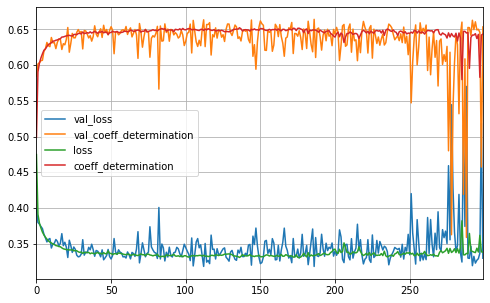

In [117]:
def save_keras_model(model, history, file_name):
    model_json = model.to_json()
    with open("../models/failure_predicting/{}.json".format(file_name), 'w') as json_file:
        json_file.write(model_json)
    model.save_weights("../models/failure_predicting/{}.h5".format(file_name))
    with open('../models/failure_predicting/{}.history'.format(file_name), 'wb') as file_history:
        pickle.dump(history.history, file_history)
    print("model saved")
    
def load_nn_model(model_name):
    with open('../models/failure_predicting/{}.json'.format(model_name)) as f:
        nn_model = model_from_json(f.read())
    nn_model.load_weights('../models/failure_predicting/{}.h5'.format(model_name))
    return nn_model
    
def coeff_determination(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res/(SS_tot + K.epsilon())
    
def create_keras_model_c1(optimizer='adam', neuron=50, init='lecun_normal', act_alpha=0.01):
    model_sequences = [
        keras.layers.Dense(units=neuron, kernel_initializer=init, input_shape=x_c1_train.shape[1:]),
        keras.layers.LeakyReLU(alpha=act_alpha)
    ]
    
    for i in range(5):
        model_sequences.append(keras.layers.Dense(units=neuron, kernel_initializer=init, 
                                                  input_shape=x_c1_train.shape[1:]))
        model_sequences.append(keras.layers.LeakyReLU(alpha=act_alpha))
        
    model_sequences.append(Dense(units=1, name='score_output'))
    model_sequences.append(keras.layers.LeakyReLU(alpha=act_alpha))
    nn_model = keras.models.Sequential(model_sequences)
    
    nn_model.compile(optimizer=optimizer, loss='mse', metrics=[coeff_determination])
    return nn_model

nn_model = create_keras_model_c1(optimizer='Adadelta', neuron=50, init='lecun_uniform', act_alpha=0.05)
print("Keras model constructed")
early_stopping_cb = EarlyStopping(patience=20)
history = nn_model.fit(x_c1_train, y_c1_train, validation_data=(x_c1_test, y_c1_test), epochs=300, callbacks=[early_stopping_cb], verbose=1)
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

The training process achieved .66 r square on testing set before early stopping detected overfitting.

In [118]:
save_keras_model(nn_model, history, "c1_300_epochs")

model saved


Aggregate data and train-test split the merged data of units in cluster 2, normalizing all inputs and label values.

In [119]:
df_c2 = load_all_data(units=KMEANS_CLUSTER2_TRAIN)
x_c2_train, x_c2_test, y_c2_train, y_c2_test = get_train_test_sets(df_c2)
x_c2_train

array([[-0.40582824,  1.53180626, -0.10164621, ...,  1.18244947,
         0.19270414, -0.59490111],
       [-3.19233524, -0.07775596, -0.56446185, ..., -1.87670111,
        -0.9005034 , -0.59490111],
       [ 0.02734221, -0.80938235, -0.63806323, ..., -0.62408894,
        -0.19772712, -0.59490111],
       ...,
       [ 0.58553943,  0.82121313, -0.28706505, ...,  0.27172701,
        -1.05667591, -0.59490111],
       [ 0.16759453, -0.15242759, -0.13639712, ...,  0.57438043,
        -0.35389963, -0.59490111],
       [-2.13976175, -0.68782396, -1.06100392, ...,  0.63153761,
        -0.9005034 , -0.59490111]])

Construct Keras neural network for the dataset on cluster 2. Less layers and nerons are needed since training data becomes less. Leaky-ReLU and Adadelta optimizer still outperformed all the other options. 

Keras model constructed
Train on 24780 samples, validate on 6196 samples
Epoch 1/300
24780/24780 [==============================] - 11s 457us/step - loss: 0.6127 - coeff_determination: 0.3570 - val_loss: 0.5548 - val_coeff_determination: 0.4197
Epoch 2/300
24780/24780 [==============================] - 5s 184us/step - loss: 0.5365 - coeff_determination: 0.4397 - val_loss: 0.5514 - val_coeff_determination: 0.4292
Epoch 3/300
24780/24780 [==============================] - 4s 180us/step - loss: 0.5271 - coeff_determination: 0.4461 - val_loss: 0.5488 - val_coeff_determination: 0.4257
Epoch 4/300
24780/24780 [==============================] - 4s 180us/step - loss: 0.5225 - coeff_determination: 0.4546 - val_loss: 0.5334 - val_coeff_determination: 0.4429
Epoch 5/300
24780/24780 [==============================] - 4s 179us/step - loss: 0.5194 - coeff_determination: 0.4577 - val_loss: 0.5313 - val_coeff_determination: 0.4473
Epoch 6/300
24780/24780 [==============================] - 4s 180us/ste

24780/24780 [==============================] - 4s 178us/step - loss: 0.4570 - coeff_determination: 0.5216 - val_loss: 0.5101 - val_coeff_determination: 0.4671
Epoch 49/300
24780/24780 [==============================] - 4s 178us/step - loss: 0.4565 - coeff_determination: 0.5255 - val_loss: 0.4997 - val_coeff_determination: 0.4825
Epoch 50/300
24780/24780 [==============================] - 4s 180us/step - loss: 0.4520 - coeff_determination: 0.5261 - val_loss: 0.5074 - val_coeff_determination: 0.4726
Epoch 51/300
24780/24780 [==============================] - 4s 177us/step - loss: 0.4543 - coeff_determination: 0.5242 - val_loss: 0.5019 - val_coeff_determination: 0.4786
Epoch 52/300
24780/24780 [==============================] - 4s 179us/step - loss: 0.4515 - coeff_determination: 0.5288 - val_loss: 0.4956 - val_coeff_determination: 0.4851
Epoch 53/300
24780/24780 [==============================] - 4s 179us/step - loss: 0.4471 - coeff_determination: 0.5370 - val_loss: 0.4995 - val_coeff_det

Epoch 96/300
24780/24780 [==============================] - 4s 179us/step - loss: 0.3996 - coeff_determination: 0.5830 - val_loss: 0.4907 - val_coeff_determination: 0.4871
Epoch 97/300
24780/24780 [==============================] - 4s 181us/step - loss: 0.3976 - coeff_determination: 0.5839 - val_loss: 0.4901 - val_coeff_determination: 0.4901
Epoch 98/300
24780/24780 [==============================] - 4s 179us/step - loss: 0.4004 - coeff_determination: 0.5839 - val_loss: 0.4976 - val_coeff_determination: 0.4860
Epoch 99/300
24780/24780 [==============================] - 4s 178us/step - loss: 0.3965 - coeff_determination: 0.5867 - val_loss: 0.4920 - val_coeff_determination: 0.4891
Epoch 100/300
24780/24780 [==============================] - 4s 179us/step - loss: 0.3947 - coeff_determination: 0.5888 - val_loss: 0.5118 - val_coeff_determination: 0.4697
Epoch 101/300
24780/24780 [==============================] - 4s 180us/step - loss: 0.3938 - coeff_determination: 0.5877 - val_loss: 0.4957 

24780/24780 [==============================] - 4s 178us/step - loss: 0.3640 - coeff_determination: 0.6179 - val_loss: 0.5669 - val_coeff_determination: 0.4099
Epoch 144/300
24780/24780 [==============================] - 4s 180us/step - loss: 0.3662 - coeff_determination: 0.6196 - val_loss: 0.5077 - val_coeff_determination: 0.4708
Epoch 145/300
24780/24780 [==============================] - 4s 177us/step - loss: 0.3678 - coeff_determination: 0.6166 - val_loss: 0.5056 - val_coeff_determination: 0.4721
Epoch 146/300
24780/24780 [==============================] - 4s 180us/step - loss: 0.3625 - coeff_determination: 0.6230 - val_loss: 0.5343 - val_coeff_determination: 0.4436
Epoch 147/300
24780/24780 [==============================] - 4s 181us/step - loss: 0.3643 - coeff_determination: 0.6185 - val_loss: 0.5101 - val_coeff_determination: 0.4689
Epoch 148/300
24780/24780 [==============================] - 4s 181us/step - loss: 0.3629 - coeff_determination: 0.6218 - val_loss: 0.5232 - val_coef

24780/24780 [==============================] - 4s 178us/step - loss: 0.3375 - coeff_determination: 0.6500 - val_loss: 0.5413 - val_coeff_determination: 0.4395
Epoch 191/300
24780/24780 [==============================] - 4s 179us/step - loss: 0.3384 - coeff_determination: 0.6475 - val_loss: 0.5383 - val_coeff_determination: 0.4428
Epoch 192/300
24780/24780 [==============================] - 4s 180us/step - loss: 0.3383 - coeff_determination: 0.6481 - val_loss: 0.5102 - val_coeff_determination: 0.4733
Epoch 193/300
24780/24780 [==============================] - 4s 178us/step - loss: 0.3389 - coeff_determination: 0.6506 - val_loss: 0.5376 - val_coeff_determination: 0.4415
Epoch 194/300
24780/24780 [==============================] - 4s 179us/step - loss: 0.3368 - coeff_determination: 0.6499 - val_loss: 0.5466 - val_coeff_determination: 0.4347
Epoch 195/300
24780/24780 [==============================] - 4s 181us/step - loss: 0.3393 - coeff_determination: 0.6458 - val_loss: 0.5473 - val_coef

24780/24780 [==============================] - 4s 178us/step - loss: 0.3200 - coeff_determination: 0.6669 - val_loss: 0.5403 - val_coeff_determination: 0.4400
Epoch 238/300
24780/24780 [==============================] - 4s 179us/step - loss: 0.3200 - coeff_determination: 0.6663 - val_loss: 0.5393 - val_coeff_determination: 0.4428
Epoch 239/300
24780/24780 [==============================] - 4s 179us/step - loss: 0.3227 - coeff_determination: 0.6634 - val_loss: 0.5496 - val_coeff_determination: 0.4302
Epoch 240/300
24780/24780 [==============================] - 4s 179us/step - loss: 0.3230 - coeff_determination: 0.6635 - val_loss: 0.5452 - val_coeff_determination: 0.4343
Epoch 241/300
24780/24780 [==============================] - 4s 178us/step - loss: 0.3218 - coeff_determination: 0.6654 - val_loss: 0.5601 - val_coeff_determination: 0.4176
Epoch 242/300
24780/24780 [==============================] - 4s 180us/step - loss: 0.3198 - coeff_determination: 0.6650 - val_loss: 0.5577 - val_coef

24780/24780 [==============================] - 4s 178us/step - loss: 0.3032 - coeff_determination: 0.6849 - val_loss: 0.5533 - val_coeff_determination: 0.4270
Epoch 285/300
24780/24780 [==============================] - 4s 179us/step - loss: 0.3054 - coeff_determination: 0.6827 - val_loss: 0.5404 - val_coeff_determination: 0.4393
Epoch 286/300
24780/24780 [==============================] - 4s 180us/step - loss: 0.3066 - coeff_determination: 0.6817 - val_loss: 0.5519 - val_coeff_determination: 0.4261
Epoch 287/300
24780/24780 [==============================] - 4s 179us/step - loss: 0.3088 - coeff_determination: 0.6779 - val_loss: 0.5751 - val_coeff_determination: 0.4046
Epoch 288/300
24780/24780 [==============================] - 4s 180us/step - loss: 0.3054 - coeff_determination: 0.6805 - val_loss: 0.5771 - val_coeff_determination: 0.4014
Epoch 289/300
24780/24780 [==============================] - 4s 180us/step - loss: 0.3067 - coeff_determination: 0.6816 - val_loss: 0.5682 - val_coef

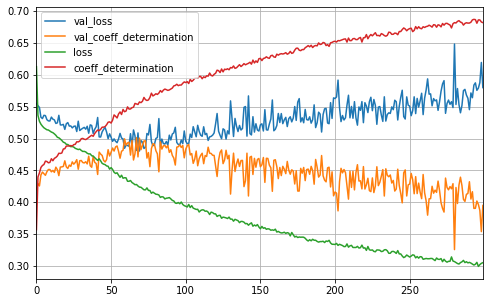

In [105]:
def create_keras_model_c2(optimizer='adam', neuron=50, init='lecun_normal', act_alpha=0.01):
    model_sequences = [
        keras.layers.Dense(units=neuron, kernel_initializer=init, input_shape=x_c2_train.shape[1:]),  
        #keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(alpha=act_alpha),        
    ]
    
    for i in range(3):
        model_sequences.append(keras.layers.Dense(units=neuron, kernel_initializer=init, 
                                                  input_shape=x_c2_train.shape[1:],
                                                  #kernel_regularizer=keras.regularizers.l2(0.01)
                                                 ))
        #model_sequences.append(keras.layers.BatchNormalization())
        model_sequences.append(keras.layers.LeakyReLU(alpha=act_alpha))
        #model_sequences.append(keras.layers.PReLU())
        
    model_sequences.append(keras.layers.Dense(units=1, name='score_output'))
    model_sequences.append(keras.layers.LeakyReLU(alpha=act_alpha))
    
    nn_model = keras.models.Sequential(model_sequences)
    
    nn_model.compile(optimizer=optimizer, loss='mse', metrics=[coeff_determination])
    return nn_model
adadelta = keras.optimizers.Adadelta(lr=1e-3)
nn_model = create_keras_model_c2(optimizer=adadelta, neuron=50, init='lecun_normal', act_alpha=0.05)
# checkpoint_cb = ModelCheckpoint("../models/failure_predicting/c2_checkpoint.h5", save_best_only=True)
print("Keras model constructed")
history = nn_model.fit(x_c2_train, y_c2_train, validation_data=(x_c2_test, y_c2_test), epochs=300, callbacks=[], verbose=1)
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

The training process showed a strong learning ability (loss kept decreasing and r square kept increasing on training set. In practise, they could even approach .99 r square and 0 loss), but overfitting happened after 60 epochs when r square on validation set began to decline.

Regularization and batch normalization were used but barely helped. Since only 5 units exist in cluster 2, the small training set caused the MLP to overfit.

Keras model constructed
Train on 24780 samples, validate on 6196 samples
Epoch 1/300
24780/24780 [==============================] - 14s 550us/step - loss: 0.6268 - coeff_determination: 0.3390 - val_loss: 0.5696 - val_coeff_determination: 0.4072
Epoch 2/300
24780/24780 [==============================] - 5s 204us/step - loss: 0.5440 - coeff_determination: 0.4294 - val_loss: 0.5559 - val_coeff_determination: 0.4200
Epoch 3/300
24780/24780 [==============================] - 5s 207us/step - loss: 0.5318 - coeff_determination: 0.4439 - val_loss: 0.5437 - val_coeff_determination: 0.4357
Epoch 4/300
24780/24780 [==============================] - 5s 205us/step - loss: 0.5267 - coeff_determination: 0.4500 - val_loss: 0.5382 - val_coeff_determination: 0.4420
Epoch 5/300
24780/24780 [==============================] - 5s 205us/step - loss: 0.5231 - coeff_determination: 0.4515 - val_loss: 0.5502 - val_coeff_determination: 0.4238
Epoch 6/300
24780/24780 [==============================] - 6s 223us/ste

24780/24780 [==============================] - 4s 181us/step - loss: 0.4283 - coeff_determination: 0.5541 - val_loss: 0.4748 - val_coeff_determination: 0.5084
Epoch 49/300
24780/24780 [==============================] - 5s 188us/step - loss: 0.4285 - coeff_determination: 0.5544 - val_loss: 0.4818 - val_coeff_determination: 0.5022
Epoch 50/300
24780/24780 [==============================] - 5s 185us/step - loss: 0.4264 - coeff_determination: 0.5563 - val_loss: 0.4870 - val_coeff_determination: 0.4941
Epoch 51/300
24780/24780 [==============================] - 5s 198us/step - loss: 0.4277 - coeff_determination: 0.5527 - val_loss: 0.4735 - val_coeff_determination: 0.5089
Epoch 52/300
24780/24780 [==============================] - 6s 231us/step - loss: 0.4251 - coeff_determination: 0.5581 - val_loss: 0.4841 - val_coeff_determination: 0.4989
Epoch 53/300
24780/24780 [==============================] - 5s 203us/step - loss: 0.4220 - coeff_determination: 0.5593 - val_loss: 0.4995 - val_coeff_det

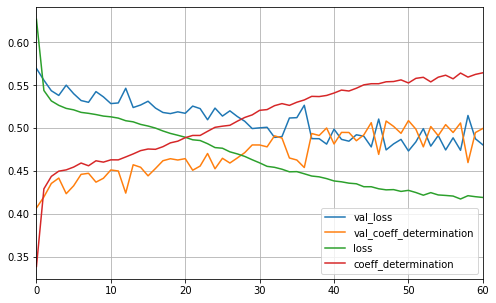

In [121]:
nn_model = create_keras_model_c2(optimizer=adadelta, neuron=50, init='lecun_normal', act_alpha=0.05)
early_stopping_cb = EarlyStopping(patience=10)
print("Keras model constructed")
history = nn_model.fit(x_c2_train, y_c2_train, validation_data=(x_c2_test, y_c2_test), epochs=300, callbacks=[early_stopping_cb], verbose=1)
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

save the model using early stopping

In [122]:
save_keras_model(nn_model, history, "c2_300_epochs")

model saved


Try random forest regressor on cluster 2 training data

In [123]:
rf_c2 = RandomForestRegressor(n_estimators=400, verbose=1, bootstrap=True, criterion='mse')
rf_c2.fit(x_c2_train, y_c2_train)
print("random forest trained, saving model...")
dump(rf_c2, '../models/failure_predicting/c2_rf.joblib')
print("saving model finished, getting validation scores...")
scores = cross_val_score(rf_c2, x_c2_train, y_c2_train, cv=3, scoring='r2')
print("cross val scores:{}".format(scores))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  1.1min finished


random forest trained, saving model...
saving model finished, getting validation scores...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   38.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   38.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   39.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


cross val scores:[0.54367031 0.55495668 0.54211399]


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    1.0s finished


400 estimators reached an R square of around .55 on 3-fold cross validation. A little bit better than MLP but not a dramatic improvement.